# Self Organising Textures

## Imports

In [5]:
import PIL
import numpy as np
from IPython.display import Image
import torch
import torchvision.models as models
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt

# Use GPU if available
USE_GPU = torch.cuda.is_available()
if (USE_GPU): torch.set_default_device('cuda')

## Loading the Target Image

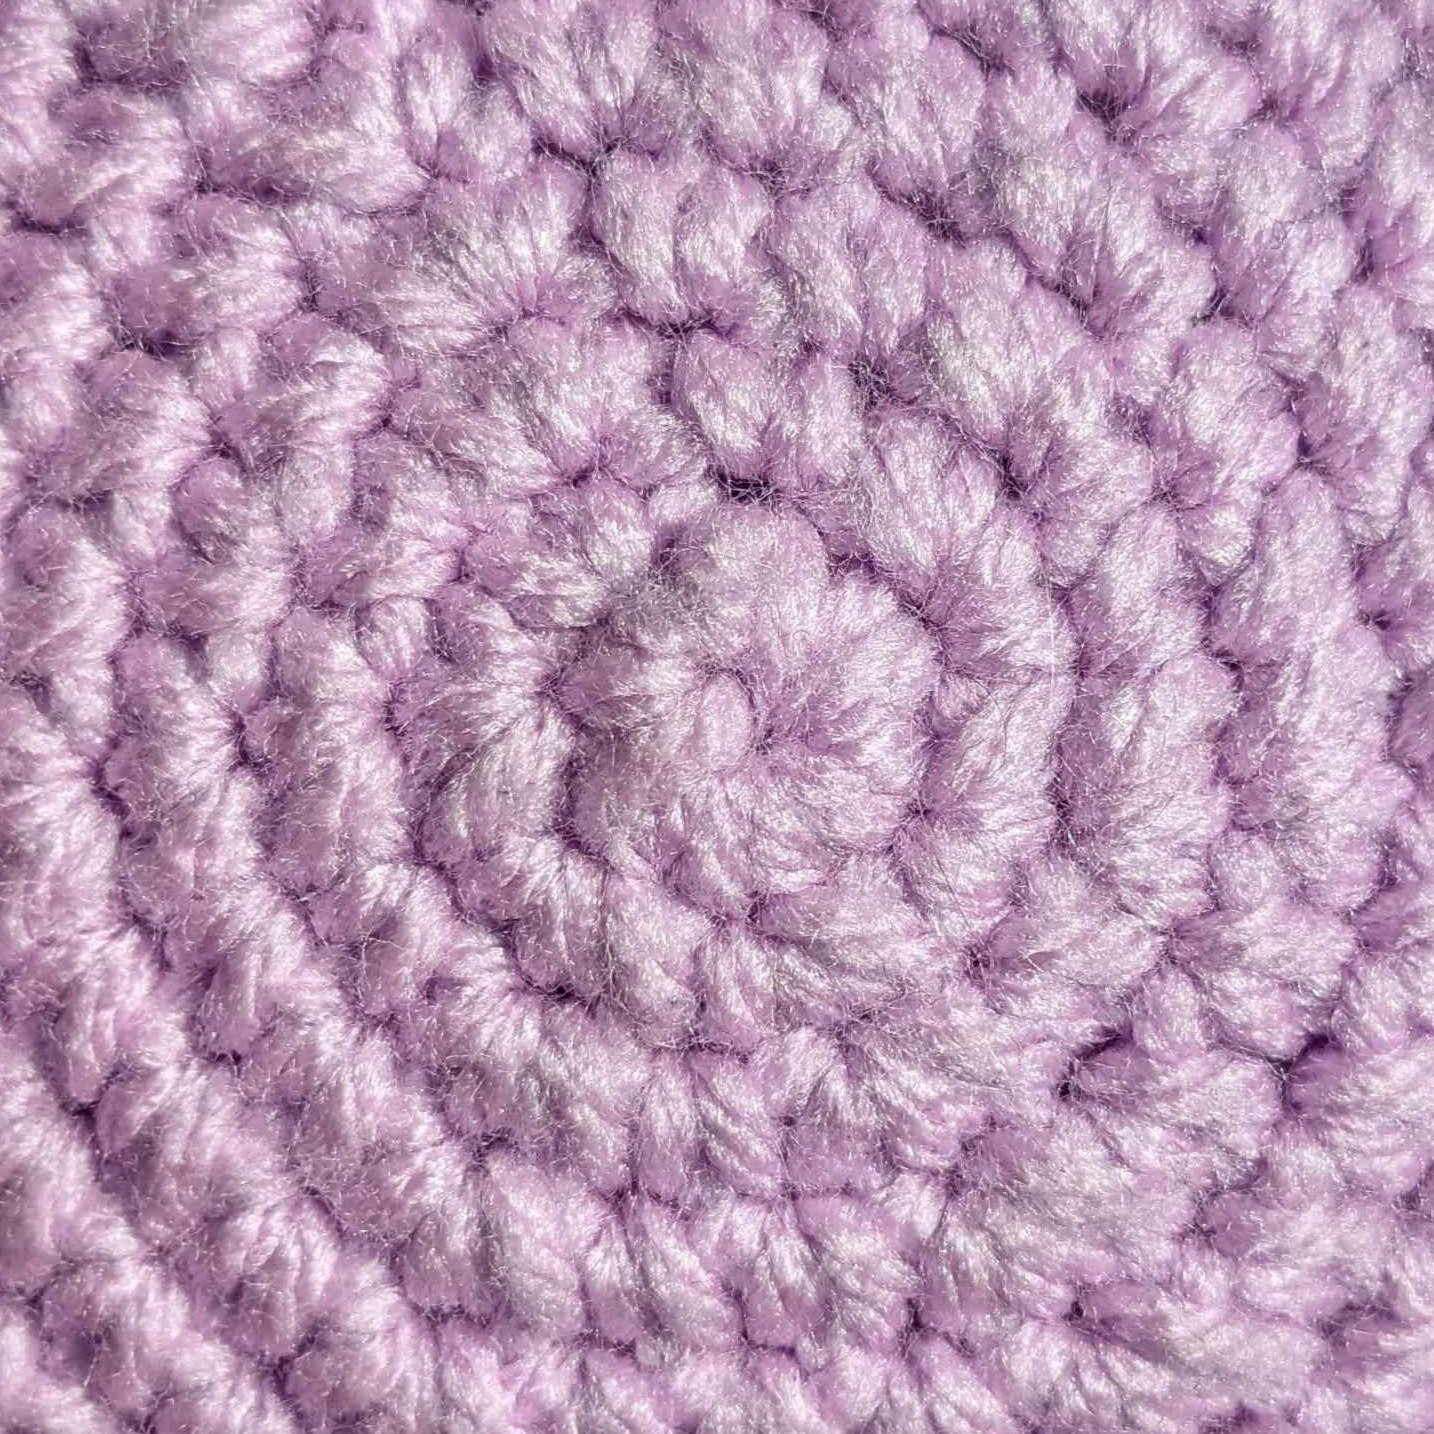

In [7]:
# Load training image
def imread(path: str, size = 256) -> np.ndarray:
    img = PIL.Image.open(path)
    img = img.thumbnail((size, size))
    img = np.array(img, dtype=np.float32)
    img = img / 255.0
    return img

# Load target image
FILE = './knit.jpg'
target = imread(FILE)
Image(filename=FILE, width=256)

## Loss Function

In [ ]:
# Load the convolutional layers of a pre-trained VGG16 model (on ImageNet)
vgg = models.vgg16(weights='IMAGENET1K_V1').features

# Layers to extract features from
STYLE_LAYERS = [1, 6, 11, 18, 25]

# Mean and Standard Deviation of ImageNet dataset
MEAN = torch.tensor([0.485, 0.456, 0.406])[:, None, None]
STD = torch.tensor([0.229, 0.224, 0.225])[:, None, None]

def extract_vgg_features(imgs: np.array):
    # Normalise images to ImageNet mean and standard deviation
    x = (imgs - MEAN) / STD

    # Reshape to batches of channels of images
    batches, channels, height, width = x.shape
    features = [x.reshape(batches, channels, height*width)]

    # Extract features from a forward pass through each style layer (up to the last layer we need)
    for i, layer in enumerate(vgg[:max(STYLE_LAYERS)+1]):
        x = layer(x)

        # Save relevant features
        if i in STYLE_LAYERS:
            features.append(x.reshape(batches, channels, height*width))

    return features

def optimal_transport_loss(sample: torch.Tensor, target: torch.Tensor, projections_n = 32) -> torch.Tensor:
    # TODO: Document and explain this function
    channels, n = sample.shape[-2:]
    projections = F.normalize(torch.randn(channels, projections_n), dim=0)
    sample_projections, target_projections = sort_projections(sample, projections), sort_projections(target, projections)
    target_interpolation = F.interpolate(target_projections, size=n, mode='nearest')
    return (sample_projections - target_interpolation).square().sum()

def sort_projections(x, proj):
  return torch.einsum('bcn,cp->bpn', x, proj).sort()[0]

def create_vgg_loss_fn(target: torch.Tensor):
    # Extract features from target image
    target_features = extract_vgg_features(target[None])

    # Define loss function
    def vgg_loss_fn(sample: torch.Tensor) -> torch.Tensor:
        sample_features = extract_vgg_features(sample)

        # Calculate optimal transport loss between each pair of features
        loss = sum(optimal_transport_loss(x, y) for x, y in zip(sample_features, target_features))
        return loss

    return vgg_loss_fn
    

## Training Setup
 - Initialising the model
 - Setting up the optimiser and learning rate scheduler

In [ ]:
from model import SelfOrganisingTexture

model = SelfOrganisingTexture()
optimiser = torch.optim.Adam(model.parameters(), lr=0.01)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimiser, milestones=[500, 1000], gamma=0.3)
loss_fn = create_vgg_loss_fn(target)

# Initialise CA state
with torch.no_grad():
  pool = model.seed(256)

## Training Loop

In [ ]:
EPOCHS = 2000
BATCH_SIZE = 4

for epoch in range(EPOCHS):
    with torch.no_grad():
        # Select a random batch of samples from the pool
        batch_idx = torch.randperm(pool.size(0))[:BATCH_SIZE]
        x = pool[batch_idx]

        # Every 8 epochs, seed the model with a new sample
        if epoch % 8 == 0:
            x[:1] = model.seed(1)

    # Run the model for a random number of steps
    steps = np.random.randint(32, 96)
    for k in range(steps):
        x = model(x)

    # Calculate loss = overflow loss + VGG loss
    overflow_loss = (x - x.clamp(-1.0, 1.0)).abs().sum()
    vgg_loss = create_vgg_loss_fn(x)
    loss = overflow_loss + vgg_loss

    # Backpropagate and update model
    with torch.no_grad():
        optimiser.zero_grad()
        loss.backward()
        optimiser.step()
        lr_scheduler.step()
